# **Code Utilising CASIA 2.0 Dataset**
*This file contains the same workflow as the other notebook, but instead utilises CASIA2.0 dataset. I have seperated the two notebooks to make it easier to view. The differences come into how the data is loaded into the application. The notebook is seperate so I can demonstrate the metrics/visualisations of my model without running both datasets (which would take too long in my presentation)*

In [ ]:

#Step 1: imports
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
from PIL import Image, ImageChops, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


import os
import time


*Working With Casia 2.0 Dataset...*

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("divg07/casia-20-image-tampering-detection-dataset") + '/CASIA2/'

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/casia-20-image-tampering-detection-dataset/CASIA2/


In [ ]:
os.listdir(path)

['CASIA 2 Groundtruth', 'Au', 'Tp']

The selected images have been copied to the `./selected_images_for_download` directory in the Colab environment.

To download this directory to your local machine, you can:

1.  In the Colab file browser (folder icon on the left sidebar), navigate to the `./selected_images_for_download` directory.
2.  Right-click on the directory.
3.  Select "Download".

Alternatively, you can use the following shell command in a new code cell (this will download a zip file of the directory):

## **Pre-Processing Stage**

In [ ]:
#Apply ELA (Error Level Analysis) to images and generate new folder...
'''
*Note: This function involve in pre-processing utilised AI tools
       to help in the development process. It opens the original file,
       resaves file with 90% quality and then calculates difference
       between (the 'ELA' part), then saves the image to ELA directory...
'''
import tempfile

def apply_ela(image_path, output_path, quality=90):
    original = Image.open(image_path).convert('RGB')
    # Use a temporary file in a writable location
    with tempfile.NamedTemporaryFile(suffix='.jpg', delete=False) as temp_file:
        temp_path = temp_file.name
        original.save(temp_path, 'JPEG', quality=quality)

    resaved = Image.open(temp_path)

    ela_image = ImageChops.difference(original, resaved)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1.0
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    ela_image.save(output_path)
    os.remove(temp_path)

In [ ]:
 # Generating new dataset with ELA applied (AI Assistance for utilising os module for saving/resaving images)
def process_dataset(input_dir, output_dir):

    label_dir = {'Au': 'Authentic', 'Tp': 'Tampered'}
    for label in ['Au', 'Tp']:
        in_path = os.path.join(input_dir, label)
        out_path = os.path.join(output_dir, label_dir[label])
        # Create output directory for the label if it doesn't exist
        os.makedirs(out_path, exist_ok=True)
        for fname in  os.listdir(in_path):
            if fname.lower().endswith(('.jpg', '.jpeg')):
              apply_ela(os.path.join(in_path, fname), #Call to ELA function
              os.path.join(out_path, fname)) #Save new ELA image

# Use the path from the kagglehub download
process_dataset(path, './ELA_Dataset')

*Check Length of ELA in Original & Forged Directory*

In [ ]:

original_total = os.listdir('./ELA_Dataset/Authentic')

forged_total = os.listdir('./ELA_Dataset/Tampered')

print(f'Authentic: {len(original_total)}')
print(f'Tampered: {len(forged_total)}')

Authentic: 7437
Tampered: 2064


*View an ELA Image vs an original non-ELA Image*

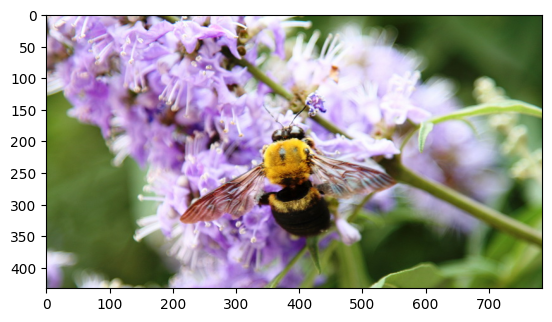

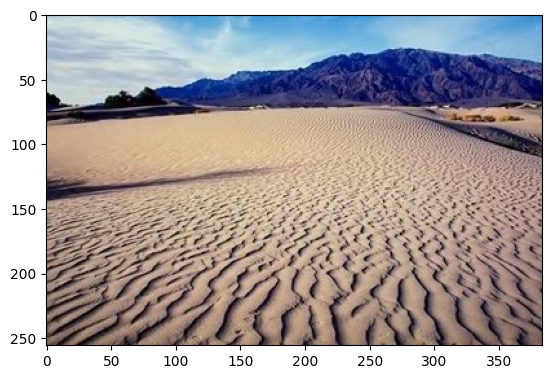

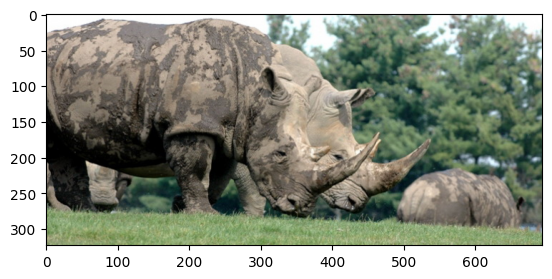

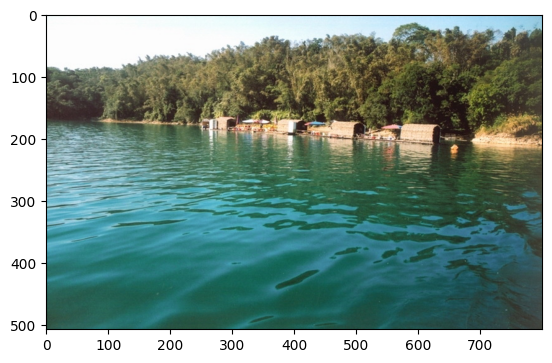

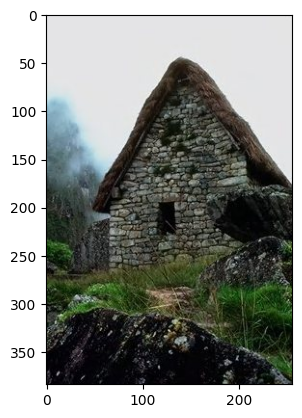

In [ ]:
#View an Image with ELA not applied (original image)...

for image in original_total[0:5]:

  image = mpimg.imread(path + '/Au/' + image)

  plt.imshow(image)
  plt.show()

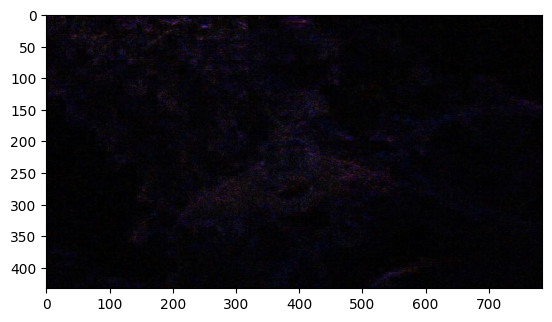

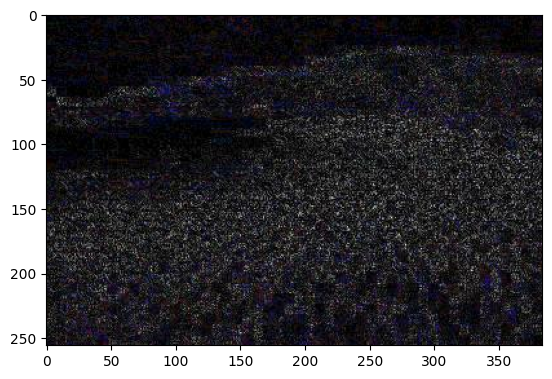

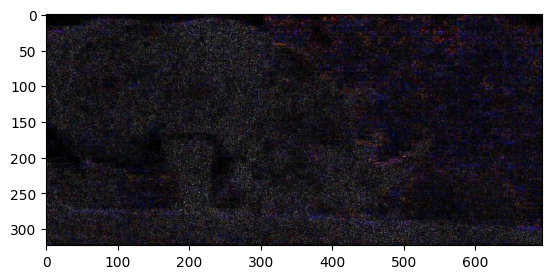

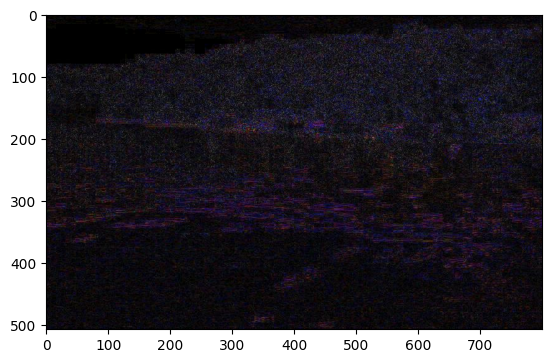

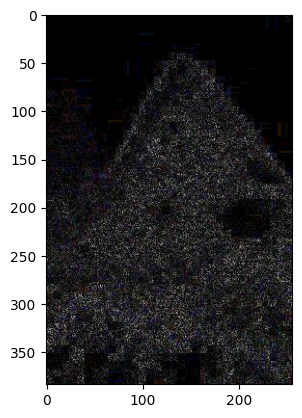

In [ ]:
#View a image with ELA applied

for image in original_total[0:5]:

  image = mpimg.imread('./ELA_Dataset/Authentic/' + image)

  plt.imshow(image)
  plt.show()

*Tampered/fraud Images with and without ELA

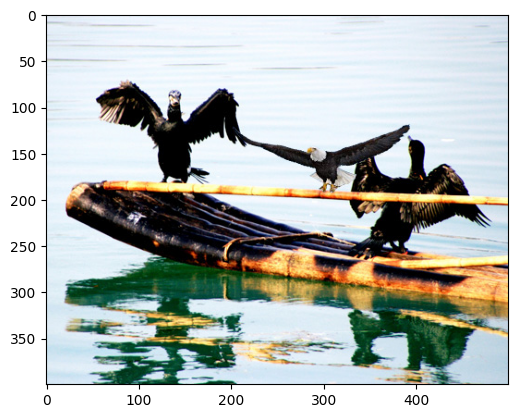

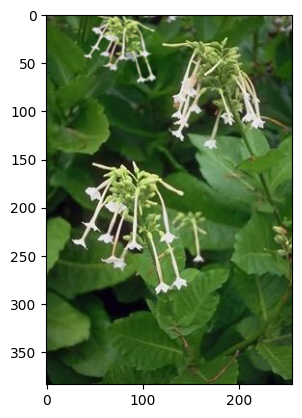

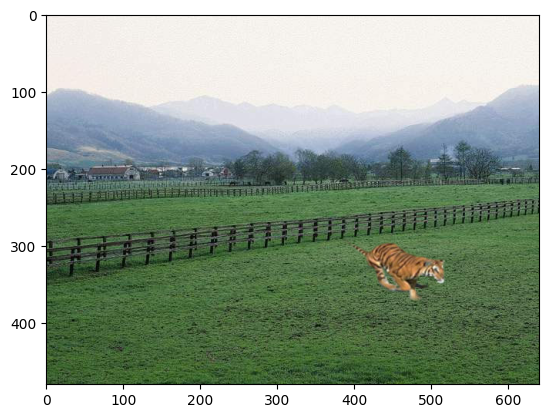

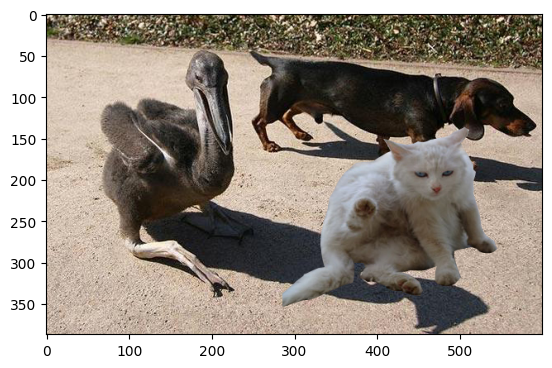

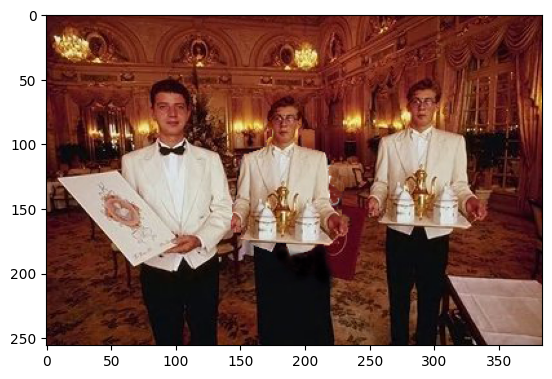

In [ ]:
#Show orged/tampered image in non-ELA format

for image in forged_total[0:5]:
  image = mpimg.imread(path+ '/Tp/'+ image)
  plt.imshow(image)
  plt.show()

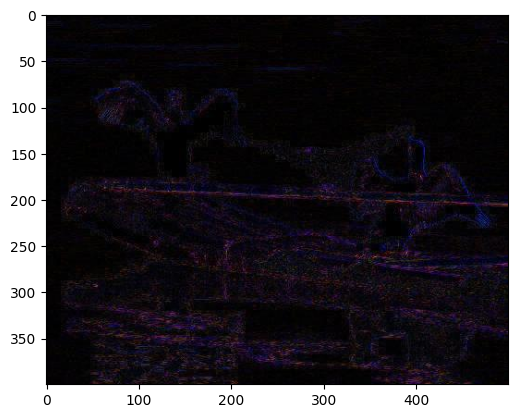

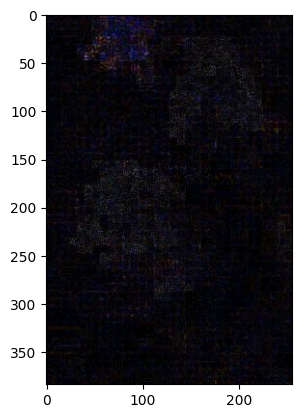

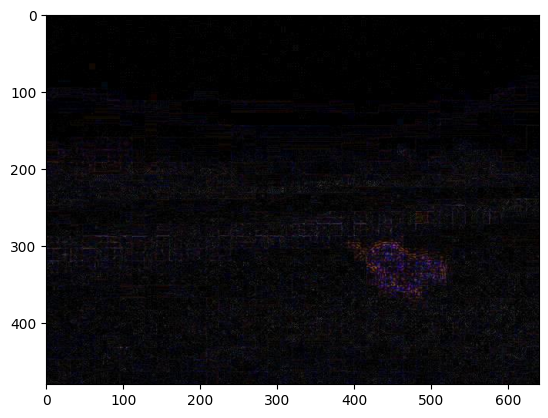

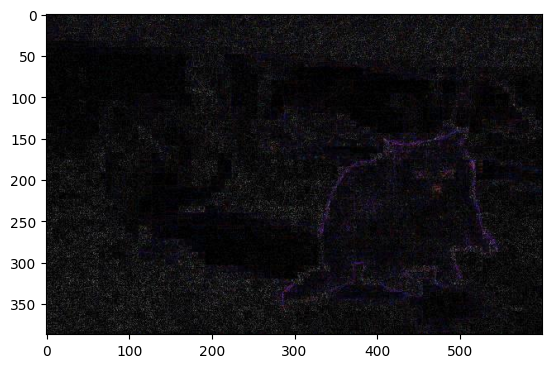

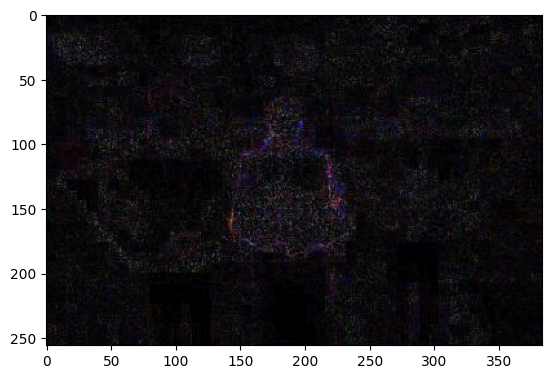

In [ ]:
#Show fraud/tampered image in ELA format...
for image in forged_total[0:5]:
  image = mpimg.imread('./ELA_Dataset/Tampered/' + image)
  plt.imshow(image)
  plt.show()

*Take only 2000 original and tampered images to be used in ML models*

In [ ]:
#ELA path
dataset_path="ELA_Dataset/"
path_original_images = 'Authentic/'
path_tampered_images = 'Tampered/'

total_original = os.listdir(dataset_path+path_original_images)[0:2000]
total_tampered = os.listdir(dataset_path+path_tampered_images)[0:2000]
print(f'Length of original images used in model is: {len(total_original)} and length of tampered is" {len(total_tampered)}')

Length of original images used in model is: 2000 and length of tampered is" 2000


*Convert the images and labels into a format to store in numpy array...*

In [ ]:
#Label for supervised learning algorithms, this will be used as 'Y' in train_test phase
#Note* This is DIFFERENT for when CNN is applied (image folder pre-decides labels)
original_label = [0] * len(total_original)
tampered_label = [1] * len(total_tampered)

In [ ]:
#Helper function to convert Image to flattened numpy array (AI assistance)
from PIL import Image

def process_image(image_path, size=(128, 128), quality=90):
    # Open and resize image
    ela_image = Image.open(image_path).convert('RGB')
    ela_image = ela_image.resize(size)

    # Convert ELA image to flattened NumPy array
    ela_array = np.array(ela_image)             # Shape: (128, 128, 3)
    flattened = ela_array.flatten()             # Shape: (128*128*3,) → (49,152,)

    return flattened

In [ ]:
features = process_image(dataset_path+path_original_images+total_original[0])
print(features.shape)  # Output: (49152,)

(49152,)


In [ ]:
X = []
#Array of x features (should be 128 * 128 * 3 features for each image)
for image in total_original:
    features = process_image(dataset_path+path_original_images+image)
    X.append(features)
print("Flattened all original images")
for image in total_tampered:
    features = process_image(dataset_path+path_tampered_images+image)
    X.append(features)
print("Falttened all tampered images")
X = np.array(X)
print(f"Shape of X is {X.shape}")

Flattened all original images
Falttened all tampered images
Shape of X is (4000, 49152)


In [ ]:
#Array of Y labels
y = original_label + tampered_label
y = np.array(y)

print(f"Shape of y (labels) is {y.shape}")

Shape of y (labels) is (4000,)


In [ ]:
print(f"Any nulls in X...{np.isnan(X).any()}")
print(f"Any nulls in y...{np.isnan(y).any()}")

Any nulls in X...False
Any nulls in y...False


In [ ]:
print(f"Datatype of X...{X.dtype}")
print(f"Datatype of y...{y.dtype}")

Datatype of X...uint8
Datatype of y...int64


## **Splitting into train-test split**
*Used for training and testing within the model*

In [ ]:
from sklearn.model_selection import train_test_split

#Will use a train/test split of 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(X_train.shape[0], "samples in training set")
print(X_test.shape[0], "samples in test set")

3200 samples in training set
800 samples in test set


## **Logistic Regression (default)**
*Logistic regression model with default hyper params*

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

model_results = {}

''''
Function for testing models using relevant metrics...
(Utilises Tutorial 7 code as base)
'''

def get_model_results(model,X_train,X_test,y_train,y_test):
    #Fit logisitc regression with train data and print train accuracy
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()

    y_pred = model.predict(X_test)

    results = {
        "fit_time": end - start,
        "training_accuracy": model.score(X_train, y_train)*100,
        "cv_accuracy": cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean() * 100,
        "testing_accuracy": accuracy_score(y_test, y_pred)*100,
        "testing_precision": precision_score(y_test, y_pred)*100,
        "testing_recall": recall_score(y_test, y_pred)*100,
        "f1_score": f1_score(y_test, y_pred)*100,
        "confusion_matrix": confusion_matrix(y_test, y_pred)
    }

    print(f'time taken for fitting: {results["fit_time"]}')
    print(f'Training accuracy: {results["training_accuracy"]}')
    print(f'Average accuracy of cross_val_score: {results["cv_accuracy"]}\n')

    #Get test accuracy, precision and recall
    print("Testing accuracy: ", results['testing_accuracy'])
    print(f'Testing Precision: {results["testing_precision"]}')
    print(f'Testing Recall: {results["testing_recall"]}')
    print(f'f1 Score: {results["f1_score"]}')

    return results

In [ ]:
from sklearn.linear_model import LogisticRegression

default_lr_model = LogisticRegression()

default_lr_model_results = get_model_results(default_lr_model, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


time taken for fitting: 38.22092843055725
Training accuracy: 100.0
Average accuracy of cross_val_score: 85.43749999999999

Testing accuracy:  82.5
Testing Precision: 77.29357798165137
Testing Recall: 89.15343915343915
f1 Score: 82.80098280098281


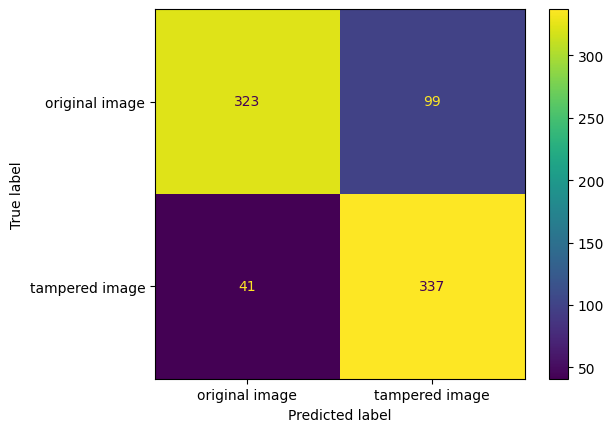

In [ ]:
#Print Confusion matrix for default model
model_results['logistic_regression_default'] = default_lr_model_results
ConfusionMatrixDisplay(default_lr_model_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

*Logistic Regression with scaled data...*

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
logistic_regression_scaled = LogisticRegression()

logistic_regression_scaled_results = get_model_results(logistic_regression_scaled, X_train_scaled, X_test_scaled, y_train, y_test)

model_results = {'logistic_regression_scaled': logistic_regression_scaled_results}

time taken for fitting: 19.73055601119995
Training accuracy: 100.0
Average accuracy of cross_val_score: 84.5

Testing accuracy:  82.875
Testing Precision: 76.83741648106904
Testing Recall: 91.26984126984127
f1 Score: 83.4340991535671


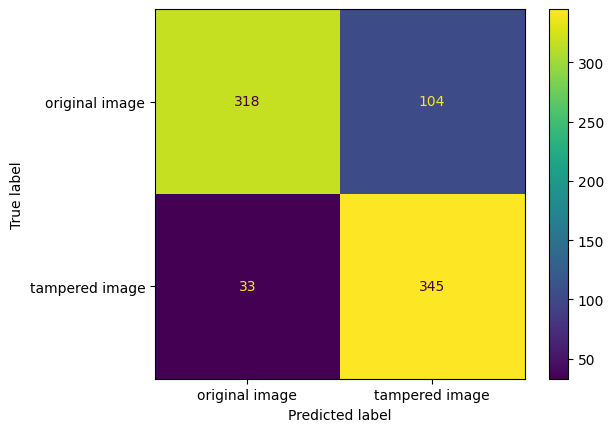

In [ ]:
ConfusionMatrixDisplay(logistic_regression_scaled_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

# **LDA & PCA Analysis**
*Lets generate both an LDA and PCA version of the dataset and then apply logistic regression*

*Generate an dimension reduced version of X using LDA and view shape*

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#Reduce feature space with LDA...
lda_model = LDA()

lda_model.fit(X_train, y_train)

#Generate train and test datasets
X_train_lda = lda_model.transform(X_train)

X_test_lda = lda_model.transform(X_test)

In [ ]:
X_train_lda.shape

(3200, 1)

*Dimensionaly reduce X using PCA and view shape*

In [ ]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=0.95)

pca_model.fit(X_train)
print(pca_model.explained_variance_ratio_)

[3.00467001e-01 5.16651807e-02 2.70722998e-02 ... 8.07950121e-05
 8.07096327e-05 8.06370171e-05]


In [ ]:
X_train_pca = pca_model.transform(X_train)
X_test_pca = pca_model.transform(X_test)
print(f"Shape of X train pca: {X_train_pca.shape}")

Shape of X train pca: (3200, 1562)


*View cumulative explain variance of PCA with graph...*

Text(0, 0.5, 'cumulative explained variance')

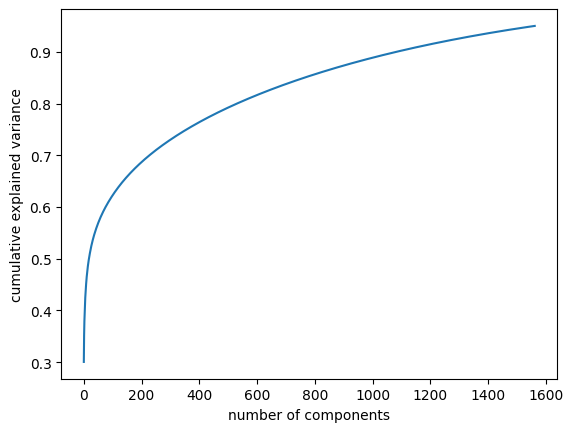

In [ ]:
#Found useful graphing function on stack-overflow
# https://stackoverflow.com/questions/53802098/how-to-choose-the-number-of-components-pca-scikitliear
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

*View training and testing success of standard logistic regression with PCA and LDA*

*LDA results...*

In [ ]:
logistic_regression_lda = LogisticRegression()

logistic_regression_lda_results = get_model_results(logistic_regression_lda, X_train_lda, X_test_lda, y_train, y_test)

model_results['logistic_regression_lda'] = logistic_regression_lda_results

time taken for fitting: 0.008560657501220703
Training accuracy: 99.09375
Average accuracy of cross_val_score: 99.125

Testing accuracy:  75.0
Testing Precision: 68.54166666666667
Testing Recall: 87.03703703703704
f1 Score: 76.68997668997669


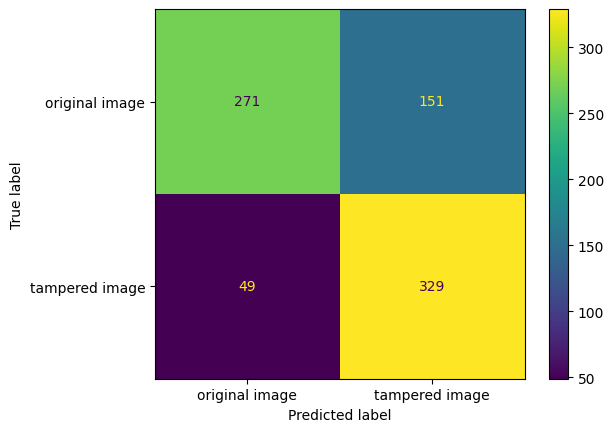

In [ ]:
ConfusionMatrixDisplay(logistic_regression_lda_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

*PCA Results...*

In [ ]:
logistic_regression_pca = LogisticRegression(max_iter=3000)

logistic_regression_pca_results = get_model_results(logistic_regression_pca, X_train_pca, X_test_pca, y_train, y_test)

model_results['logistic_regression_pca'] = logistic_regression_pca_results

time taken for fitting: 13.34548044204712
Training accuracy: 100.0
Average accuracy of cross_val_score: 78.28125

Testing accuracy:  81.875
Testing Precision: 76.5375854214123
Testing Recall: 88.88888888888889
f1 Score: 82.25214198286413


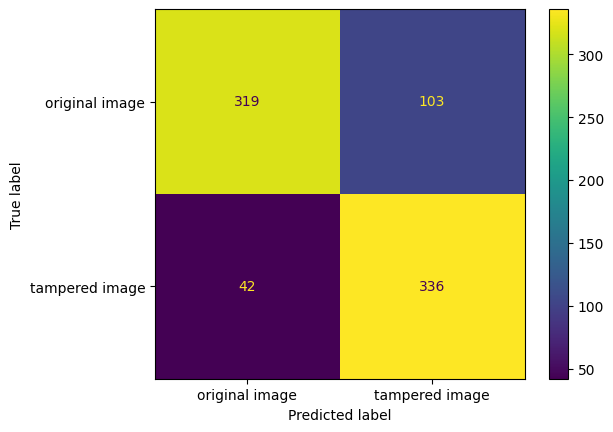

In [ ]:
ConfusionMatrixDisplay(logistic_regression_pca_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

Handling overfitting of training accuracy on PCA...

*Reducing PCA components and and seeing how it impacts model...*

In [ ]:
pca_model_2 = PCA(n_components=1000)


X_train_pca_1000 = pca_model_2.fit_transform(X_train)
X_test_pca_1000 = pca_model_2.transform(X_test)

logistic_regression_pca_1000 = LogisticRegression(max_iter = 3000)

logistic_regression_pca_1000_results = get_model_results(logistic_regression_pca_1000, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

model_results['logistic_regression_pca_1000'] = logistic_regression_pca_1000_results


time taken for fitting: 30.67359209060669
Training accuracy: 100.0
Average accuracy of cross_val_score: 76.93749999999999

Testing accuracy:  80.0
Testing Precision: 74.22222222222223
Testing Recall: 88.35978835978835
f1 Score: 80.67632850241546


*Finding maximum value of c for LDA and PCA*

In [ ]:

#c values to test
def find_c_hyperparam(x_train, y_train):
  c_values = [0.01, 0.1, 1, 10, 100, 1000] # Values of C to check...

  acc_c = []

  for c in c_values:
      lr_model = LogisticRegression(C=c, max_iter = 3000)
      #use cross validation to create train and validation sets out of 5 folds
      scores = cross_val_score(lr_model, x_train, y_train, cv=5, scoring='accuracy')
      acc_c.append(scores.mean())
  print("Best C: ", c_values[np.argmax(acc_c)])

  return c_values[np.argmax(acc_c)]

In [ ]:
start = time.time()
find_c_hyperparam(X_train_lda, y_train)
end = time.time()
print(f'total time to find best c for lda: {end - start}')

Best C:  0.01
total time to find best c for lda: 0.24309945106506348


In [ ]:
start = time.time()
find_c_hyperparam(X_train_pca_1000, y_train)
end = time.time()
print(f'total time to find best c for pca: {end - start}')

Best C:  1000
total time to find best c for pca: 494.06145429611206


Testing results for maximised c value for LDA & PCA

In [ ]:
print("LDA improved c value...")


model_lda = LogisticRegression(C=0.01)
res = get_model_results(model_lda, X_train_lda, X_test_lda, y_train, y_test)


LDA improved c value...
time taken for fitting: 0.06561040878295898
Training accuracy: 99.09375
Average accuracy of cross_val_score: 99.125

Testing accuracy:  75.0
Testing Precision: 68.54166666666667
Testing Recall: 87.03703703703704
f1 Score: 76.68997668997669


In [ ]:
print("PCA improved c value...")

model_pca = LogisticRegression(C=10)
res = get_model_results(model_pca, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

PCA improved c value...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

time taken for fitting: 1.8968286514282227
Training accuracy: 99.40625
Average accuracy of cross_val_score: 78.84375

Testing accuracy:  80.375
Testing Precision: 74.50110864745011
Testing Recall: 88.88888888888889
f1 Score: 81.0615199034982


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*Using the speed of LDA to maximise parameters*

In [ ]:
from sklearn.model_selection import GridSearchCV
# Function for finding optimal hyper parameters
def optimise(model, param_grid, X_train, y_train):
    grid = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid.fit(X_train, y_train)

    print("Best CV accuracy:", grid.best_score_)
    return grid.best_params_

In [ ]:
#Maximising parameters of LDA...
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # safest with both l1 and l2
    'max_iter': [3000]        # ensure convergence
}

lr_lda_maximised = LogisticRegression()

best_lda_lr_params = optimise(lr_lda_maximised, param_grid, X_train_lda, y_train)

print("Best params:", best_lda_lr_params)


Best CV accuracy: 0.99125
Best params: {'C': 0.001, 'max_iter': 3000, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
print("LDA Logistic Regression maximised...")


model_lda = LogisticRegression(C=0.01, max_iter=3000, penalty='l1', solver='liblinear')

logistic_regression_lda_maximised_results = get_model_results(model_lda, X_train_lda, X_test_lda, y_train, y_test)

model_results['logistic_regression_lda_maximised'] = logistic_regression_lda_maximised_results



LDA Logistic Regression maximised...
time taken for fitting: 0.0039751529693603516
Training accuracy: 99.125
Average accuracy of cross_val_score: 99.125

Testing accuracy:  75.25
Testing Precision: 68.90756302521008
Testing Recall: 86.77248677248677
f1 Score: 76.81498829039812


LDA results with maximising hyperparams...


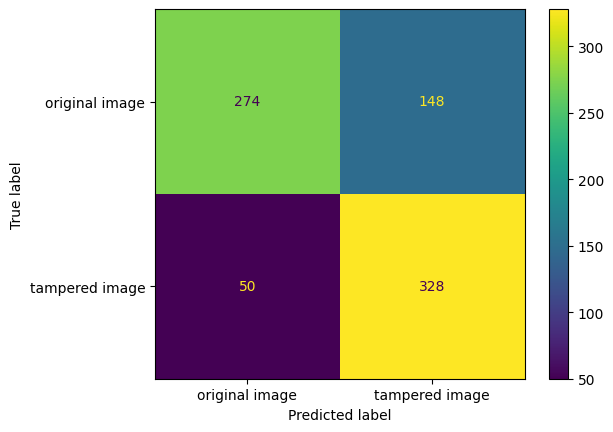

In [ ]:
print("LDA results with maximising hyperparams...")
ConfusionMatrixDisplay(logistic_regression_lda_maximised_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

Maximise parameters for PCA

In [ ]:
#Maximising parameters of PCA...
from sklearn.model_selection import GridSearchCV

#Utilised sklearn docs & GeeksForGeeks docs...
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  # safest with both l1 and l2
    'max_iter': [3000]        # ensure convergence
}

lr_pca_maximised = LogisticRegression()

best_pca_lr_params = optimise(lr_pca_maximised, param_grid, X_train_pca_1000, y_train)

print("Best params:", best_pca_lr_params)

Best CV accuracy: 0.8359375
Best params: {'C': 0.001, 'max_iter': 3000, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
print("PCA Logistic Regression maximised...")


model_pca = LogisticRegression(C=0.001, max_iter=3000, penalty='l1', solver='liblinear')

logistic_regression_pca_maximised_results = get_model_results(model_pca, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

model_results['logistic_regression_pca_maximised'] = logistic_regression_pca_maximised_results


PCA Logistic Regression maximised...
time taken for fitting: 0.3393545150756836
Training accuracy: 89.8125
Average accuracy of cross_val_score: 83.625

Testing accuracy:  80.75
Testing Precision: 74.56140350877193
Testing Recall: 89.94708994708994
f1 Score: 81.5347721822542


PCA results with maximising hyperparams...


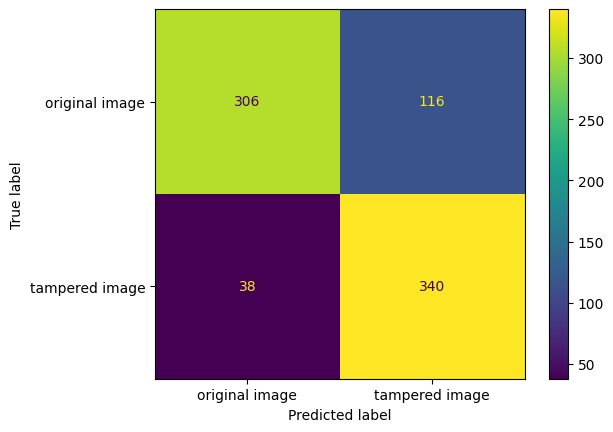

In [ ]:
print("PCA results with maximising hyperparams...")
ConfusionMatrixDisplay(logistic_regression_pca_maximised_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

## **SVM Models**
*Applying linear & non-linear SVM with PCA & LDA feature reduction dataset *

In [ ]:
from sklearn.svm import SVC


*Testing Linear kernel with LDA and PCA (default parameters)*

In [ ]:
print("Linear kernel with LDA...")
svc = SVC(kernel='linear')
svc_linear_lda_results = get_model_results(svc, X_train_lda, X_test_lda, y_train, y_test)

model_results['svc_linear_lda'] = svc_linear_lda_results

Linear kernel with LDA...
time taken for fitting: 0.10034561157226562
Training accuracy: 99.125
Average accuracy of cross_val_score: 99.125

Testing accuracy:  74.875
Testing Precision: 68.24742268041237
Testing Recall: 87.56613756613757
f1 Score: 76.70915411355736


In [ ]:
print("Linear kernel with PCA...")

svc_linear_pca_results = get_model_results(svc, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

model_results['svc_linear_pca'] = svc_linear_pca_results

Linear kernel with PCA...
time taken for fitting: 10.600497007369995
Training accuracy: 100.0
Average accuracy of cross_val_score: 76.3125

Testing accuracy:  81.0
Testing Precision: 76.52582159624414
Testing Recall: 86.24338624338624
f1 Score: 81.09452736318407


*Hyper-parameter tuning for SVC with LDA dataset*

In [ ]:
#Finding optimal kernel for LDA dataset...

param_grid = {
    "kernel": ['linear', 'rbf', 'poly', 'sigmoid']
}

svc = SVC()
best_kernel = optimise(svc, param_grid, X_train_lda, y_train)['kernel']
best_kernel


Best CV accuracy: 0.9928125


'rbf'

In [ ]:
#Find best c value with optimal kernel...
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}

svc = SVC(kernel = best_kernel)
best_c = optimise(svc, param_grid, X_train_lda, y_train)['C']
best_c

Best CV accuracy: 0.993125


10

In [ ]:
#find best degree value with optimal "C" and Kernel...
param_grid = {
    "degree": list(range(2,10,1))
}

svc = SVC(kernel = best_kernel, C = best_c)

best_degree = optimise(svc, param_grid, X_train_lda, y_train)['degree']
best_degree

Best CV accuracy: 0.993125


2

In [ ]:
#Evaluate SVC with optimised parameters using LDA dataset
svc = SVC(kernel=best_kernel, C=best_c, degree=best_degree)
svc_lda_maximised_results = get_model_results(svc, X_train_lda, X_test_lda, y_train, y_test)

model_results['svc_lda_maximised'] = svc_lda_maximised_results

time taken for fitting: 0.09463143348693848
Training accuracy: 99.4375
Average accuracy of cross_val_score: 99.3125

Testing accuracy:  65.25
Testing Precision: 58.68055555555556
Testing Recall: 89.41798941798942
f1 Score: 70.85953878406708


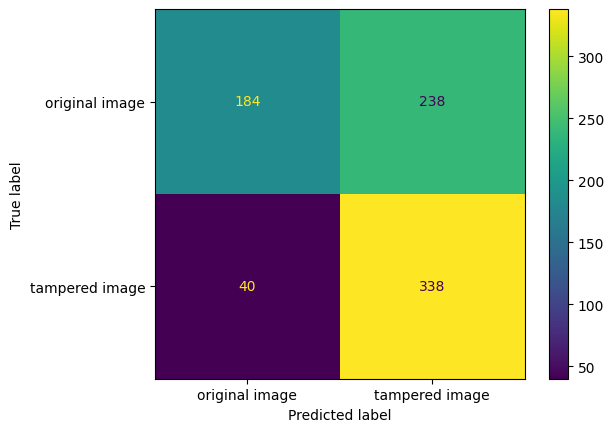

In [ ]:
ConfusionMatrixDisplay(svc_lda_maximised_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

*Hyper-parameter tuning for SVC with PCA dataset (same process as above)*

In [ ]:
#Optimising PCA dataset with alternate kernel

param_grid = {
    "kernel": ['linear', 'rbf', 'poly', 'sigmoid']
}

svc = SVC()
best_kernel_pca = optimise(svc, param_grid, X_train_pca_1000, y_train)['kernel']
best_kernel_pca

Best CV accuracy: 0.9009375000000001


'rbf'

In [ ]:
#Find best c value with optimal kernel...
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100]
}

svc = SVC(kernel = best_kernel_pca)
best_c_pca = optimise(svc, param_grid, X_train_pca_1000, y_train)['C']
best_c_pca

Best CV accuracy: 0.9009375000000001


1

In [ ]:
#find best degree value with optimal "C" and Kernel...
param_grid = {
    "degree": list(range(2,10,1))
}

svc = SVC(kernel = best_kernel_pca, C = best_c_pca)

best_degree_pca = optimise(svc, param_grid, X_train_pca_1000, y_train)['degree']
best_degree_pca

Best CV accuracy: 0.9009375000000001


2

In [ ]:
#Evaluate SVC with optimised parameters using PCA dataset
svc = SVC(kernel=best_kernel_pca, C=best_c_pca, degree=best_degree_pca)
svc_pca_maximised_results = get_model_results(svc, X_train_pca_1000, X_test_pca_1000, y_train, y_test)

model_results['svc_pca_maximised'] = svc_pca_maximised_results

time taken for fitting: 4.040210723876953
Training accuracy: 93.84375
Average accuracy of cross_val_score: 90.09375

Testing accuracy:  82.25
Testing Precision: 74.08163265306122
Testing Recall: 96.03174603174604
f1 Score: 83.6405529953917


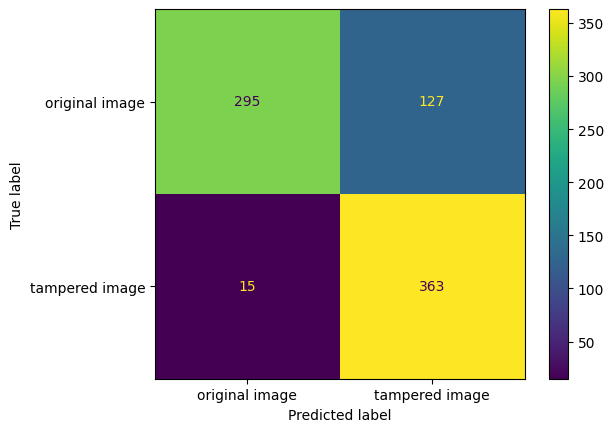

In [ ]:
ConfusionMatrixDisplay(svc_pca_maximised_results['confusion_matrix'], display_labels=['original image','tampered image']).plot()

# **CNN Model**

In [ ]:
# transform data for pre-normalisation step

# Transform without normalization (for mean/std)
'''
Note: A large portion of code for CNN transformation
      and development was taken from tutorial with slight
      modification to hyper-parameters to better fit/model
      data
'''
temp_transform = transforms.Compose([
    transforms.Grayscale(),
      transforms.RandomRotation(5, fill=(0,)), # Data augmentation
    transforms.RandomCrop(128, padding=2),    # Data augmentation
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [ ]:
#ImageFolder is a class in pytorch used for loading image data
#That is sorted in folder format (./Forged, ./Original) representing
#their class
dataset = datasets.ImageFolder('ELA_Dataset/', transform=temp_transform)

In [ ]:
#View image entry converted to tensor
dataset[0]

(tensor([[[0.0314, 0.0784, 0.0824,  ..., 0.0902, 0.0863, 0.0902],
          [0.0627, 0.0353, 0.0196,  ..., 0.0745, 0.0706, 0.0588],
          [0.0431, 0.0039, 0.0039,  ..., 0.0314, 0.0275, 0.0118],
          ...,
          [0.0471, 0.0824, 0.0745,  ..., 0.0510, 0.0745, 0.1216],
          [0.0706, 0.0510, 0.0118,  ..., 0.0784, 0.0980, 0.1255],
          [0.1020, 0.0902, 0.0549,  ..., 0.0824, 0.0980, 0.1098]]]),
 0)

In [ ]:
# label 0 is Forged, label 1 is Original
print(dataset.class_to_idx)

{'Authentic': 0, 'Tampered': 1}


In [ ]:
# Generate train, val and test splits

# Manually select 2000 jpeg/jpg samples from each class (AI Assistance)
original_indices = [i for i, (path, label) in enumerate(dataset.samples) if dataset.classes[label] == 'Authentic' and (path.lower().endswith('.jpg') or path.lower().endswith('.jpeg'))][:2000]
forged_indices = [i for i, (path, label) in enumerate(dataset.samples) if dataset.classes[label] == 'Tampered' and (path.lower().endswith('.jpg') or path.lower().endswith('.jpeg'))][:2000]

# Combine the indices
subset_indices = original_indices + forged_indices

# Create a Subset of the dataset using the selected indices
subset_dataset = Subset(dataset, subset_indices)

print(f"length of of dataset...{len(subset_dataset)}")


length of of dataset...4000


In [ ]:
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_set, test_set = random_split(subset_dataset, [train_size, test_size])
print(f"length of train set: {len(train_set)}")
print(f"length of test set: {len(test_set)}")

length of train set: 3200
length of test set: 800


In [ ]:
val_percentage = 0.2

val_size = int(val_percentage * len(train_set))
train_size = len(train_set) - val_size

train_set, val_set = random_split(train_set, [train_size, val_size])

In [ ]:
print(f"Length of train set: {len(train_set)}")
print(f"length of val set: {len(val_set)}")
print(f"length of test set: {len(test_set)}")

Length of train set: 2560
length of val set: 640
length of test set: 800


In [ ]:
# Compute mean and std of training data
'''
Note: Function utilised AI assistance throughout development
'''
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total += batch_samples

    mean /= total
    std /= total
    return mean, std

mean, std = compute_mean_std(train_set)

In [ ]:
print('mean: ' + str(mean.tolist()[0]))
print('std: ' + str(std.tolist()[0]))

mean: 0.05350753664970398
std: 0.04822135716676712


In [ ]:
#Redefine with normalisation

'''
Tutorial code + minor AI assistance for finding helper classes/methods
From this point on, a large portion of code is taken from the tutorial and
modified with hyper-params
'''
train_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(5, fill=(0,)), # Data augmentation
    transforms.RandomCrop(128, padding=2),    # Data augmentation
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

# Apply to datasets
dataset.transform = train_transform
train_set.dataset.transform = train_transform
val_set.dataset.transform = train_transform
test_set.dataset.transform = train_transform

In [ ]:
#Create interator through dataloaders
BATCH_SIZE = 64

train_iterator = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_iterator = DataLoader(val_set, batch_size=BATCH_SIZE)
test_iterator = DataLoader(test_set, batch_size=BATCH_SIZE)

In [ ]:
#Creating neural network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class LeNet(nn.Module):
    def __init__(self, output_dim=10):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=6,
                               kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,
                              out_channels=16,
                            kernel_size=5)


        self.fc1 = nn.Linear(16 * 29 * 29, 120) #For 128 bit image
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):
        # [batch_size, 1, 28, 28]
        x = self.conv1(x)

        # [batch_size, 6,24 ,24]
        x = F.max_pool2d(x, kernel_size=2)
        # [batch_size, 6, 12 ,12]

        x = F.relu(x)
        x = self.conv2(x)
        # [batch_size, 16, 8 ,8]

        x = F.max_pool2d(x, kernel_size=2)
        # [batch_size, 16, 4 ,4]

        x = F.relu(x)

        x = x.view(x.shape[0], -1)
        # [batch_size, 16* 4 * 4]

        x = self.fc1(x)

        x = F.relu(x)

        x = self.fc2(x)

        x = F.relu(x)

        x = self.fc3(x)


        return x

In [ ]:
OUTPUT_DIM = 10

model = LeNet(OUTPUT_DIM)

model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 1,628,426 trainable parameters


## **Training the CNN model**

In [ ]:
#Define the optimizer
optimizer = optim.Adam(model.parameters())

In [ ]:
#Loss function...
criterion = nn.CrossEntropyLoss()

In [ ]:
#Device on CPU or GPU...
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss, epoch_acc = 0, 0

    model.train()

    for (item, label) in iterator:
        item, label = item.to(device), label.to(device)

        optimizer.zero_grad()

        y_pred = model(item)

        loss = criterion(y_pred, label)

        acc = calculate_accuracy(y_pred, label)

        loss.backward()
        optimizer.step()

        # log

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss, epoch_acc = 0, 0

    model.eval()

    with torch.no_grad():
        for (item, label) in iterator:
            item, label = item.to(device), label.to(device)

            y_pred = model(item)

            loss = criterion(y_pred, label)

            acc = calculate_accuracy(y_pred, label)


            # log

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 32

best_valid_loss = float('inf')

train_accs = []
valid_accs = []

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, val_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

Epoch: 01 | Epoch Time: 0m 26s
	Train Loss: 0.669 | Train Acc: 66.33%
	 Val. Loss: 0.530 |  Val. Acc: 75.62%
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 0.543 | Train Acc: 73.63%
	 Val. Loss: 0.560 |  Val. Acc: 72.66%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.511 | Train Acc: 75.59%
	 Val. Loss: 0.478 |  Val. Acc: 80.78%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.475 | Train Acc: 78.59%
	 Val. Loss: 0.464 |  Val. Acc: 81.25%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.416 | Train Acc: 82.34%
	 Val. Loss: 0.411 |  Val. Acc: 83.59%
Epoch: 06 | Epoch Time: 0m 25s
	Train Loss: 0.382 | Train Acc: 84.06%
	 Val. Loss: 0.372 |  Val. Acc: 87.19%
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 0.401 | Train Acc: 83.32%
	 Val. Loss: 0.399 |  Val. Acc: 84.38%
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.372 | Train Acc: 85.23%
	 Val. Loss: 0.363 |  Val. Acc: 85.31%
Epoch: 09 | Epoch Time: 0m 24s
	Train Loss: 0.360 | Train Acc: 85.55%
	 Val. Loss: 0.364 |  Val. Acc: 84.69%
Epoch: 10 | Epoch T

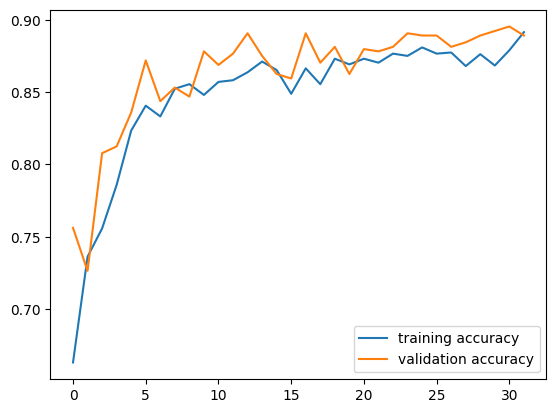

In [ ]:
plt.plot(train_accs, label="training accuracy")
plt.plot(valid_accs, label = "validation accuracy")
plt.legend()
plt.show()


In [ ]:

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.309 | Test Acc: 87.02%


In [ ]:
# Function to get relevant predictions of model
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
#Store the image, labels and probabilities of predictions
images, labels, probs = get_predictions(model, test_iterator, device)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(2));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    ax.xaxis.set_ticklabels(['forged', 'original']); ax.yaxis.set_ticklabels(['forged', 'original'])

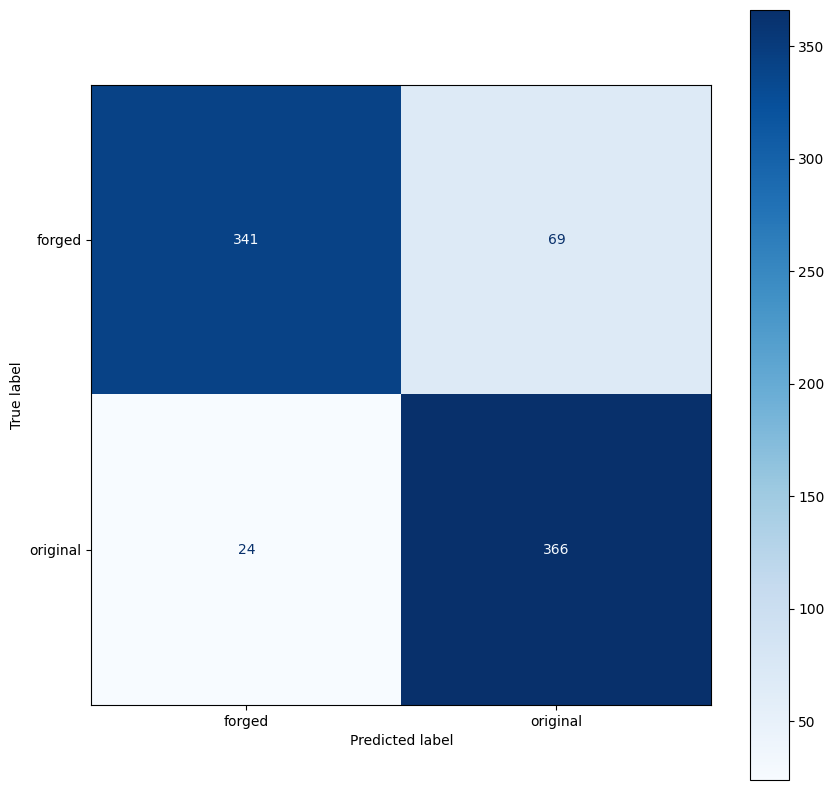

In [ ]:
plot_confusion_matrix(labels, pred_labels)

In [ ]:
#Get correct predictions
corrects = torch.eq(labels, pred_labels)

In [ ]:
#Get incorrect predictions
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(128, 128).cpu().numpy(), cmap = 'bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

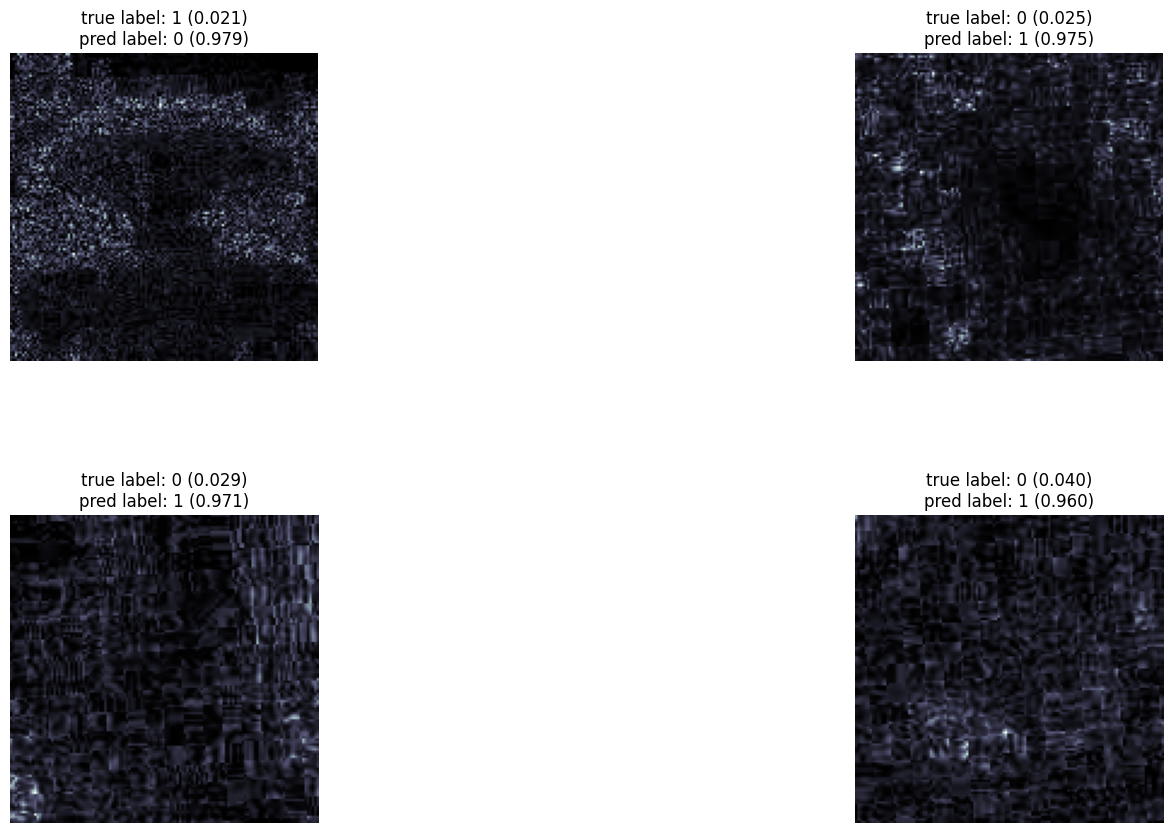

In [ ]:
N_IMAGES = 4

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [ ]:

precision = precision_score(labels, pred_labels)
recall = recall_score(labels, pred_labels)

cnn_f1_score = f1_score(labels, pred_labels)

print(f'Test Precision for CNN: {precision:.3f}')
print(f'Test Recall for CNN: {recall:.3f}')
print(f'Test F1 Score for CNN: {cnn_f1_score:.3f}')

Test Precision for CNN: 0.841
Test Recall for CNN: 0.938
Test F1 Score for CNN: 0.887


In [ ]:
# Add CNN results to model_results dictionary
model_results['cnn_model'] = {
    "cv_accuracy": max(train_accs) * 100, # Using max training accuracy as CV different in CNN models...
    "testing_accuracy": test_acc * 100,
    "testing_precision": precision * 100,
    "testing_recall": recall * 100,
    "f1_score": cnn_f1_score * 100,
    "confusion_matrix": confusion_matrix(labels, pred_labels)
}

model_results['cnn_model']

{'cv_accuracy': 89.140625,
 'testing_accuracy': 87.01923076923077,
 'testing_precision': 84.13793103448276,
 'testing_recall': 93.84615384615384,
 'f1_score': 88.72727272727273,
 'confusion_matrix': array([[341,  69],
        [ 24, 366]])}

## **Comparison**
*Generating tables and graphs for comparison purposes...*


In [ ]:
import pandas as pd
Data = {
    "Model": [],
    "Train Accuracy": [],
    "Test Accuracy": [],
    "Test Precission": [],
    "Test Recall": [],
    "Test F1 Score": []
}

for name in model_results.keys():
    Data["Model"].append(name)
    Data["Train Accuracy"].append(model_results[name]["cv_accuracy"])
    Data["Test Accuracy"].append(model_results[name]["testing_accuracy"])
    Data["Test Precission"].append(model_results[name]["testing_precision"])
    Data["Test Recall"].append(model_results[name]["testing_recall"])
    Data["Test F1 Score"].append(model_results[name]["f1_score"])

Data = pd.DataFrame(Data)
Data

Model  Train Accuracy  Test Accuracy  \
0          logistic_regression_scaled       84.500000      82.875000   
1             logistic_regression_lda       99.125000      75.000000   
2             logistic_regression_pca       78.281250      81.875000   
3        logistic_regression_pca_1000       76.937500      80.000000   
4   logistic_regression_lda_maximised       99.125000      75.250000   
5   logistic_regression_pca_maximised       83.625000      80.750000   
6                      svc_linear_lda       99.125000      74.875000   
7                      svc_linear_pca       76.312500      81.000000   
8                   svc_lda_maximised       99.312500      65.250000   
9                   svc_pca_maximised       90.093750      82.250000   
10                          cnn_model       89.140625      87.019231   

    Test Precission  Test Recall  Test F1 Score  
0         76.837416    91.269841      83.434099  
1         68.541667    87.037037      76.689977  
2         76.537585    88.888889      82.252142  
3         74.222222    88.359788      80.676329  
4         68.907563    86.772487      76.814988  
5         74.561404    89.947090      81.534772  
6         68.247423    87.566138      76.709154  
7         76.525822    86.243386      81.094527  
8         58.680556    89.417989      70.859539  
9         74.081633    96.031746      83.640553  
10        84.137931    93.846154      88.727273

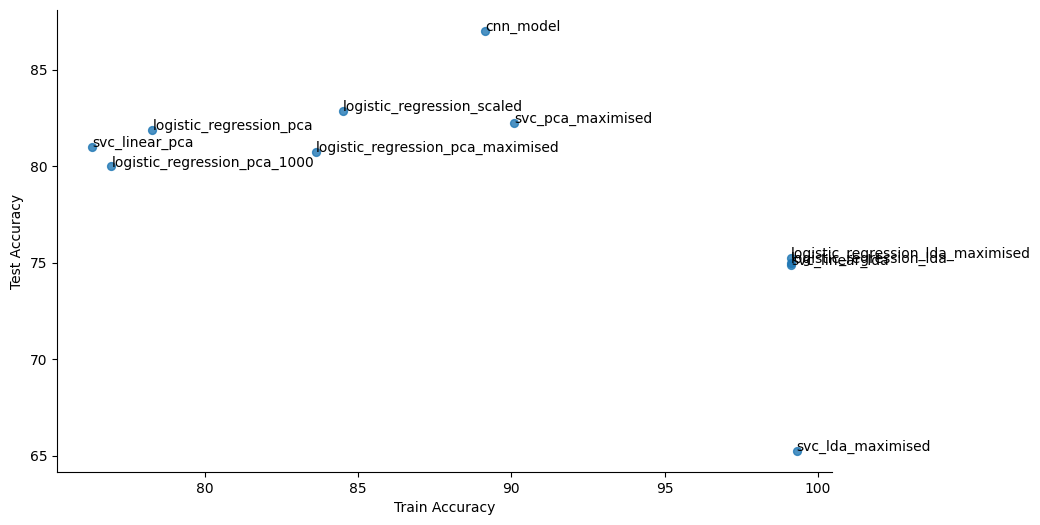

In [ ]:
#Note*** The graphs provided made use of Google Collabs built in tools for generating graphs
# From dataframes, these graphs are NOT my own code and are simply visual evaluations of the
# data...

from matplotlib import pyplot as plt
Data.plot(kind='scatter', x='Train Accuracy', y='Test Accuracy', s=32, alpha=.8, figsize=(10, 6))
plt.gca().spines[['top', 'right',]].set_visible(False)

for i, row in Data.iterrows():
    plt.annotate(row['Model'], (row['Train Accuracy'], row['Test Accuracy']))
plt.show()

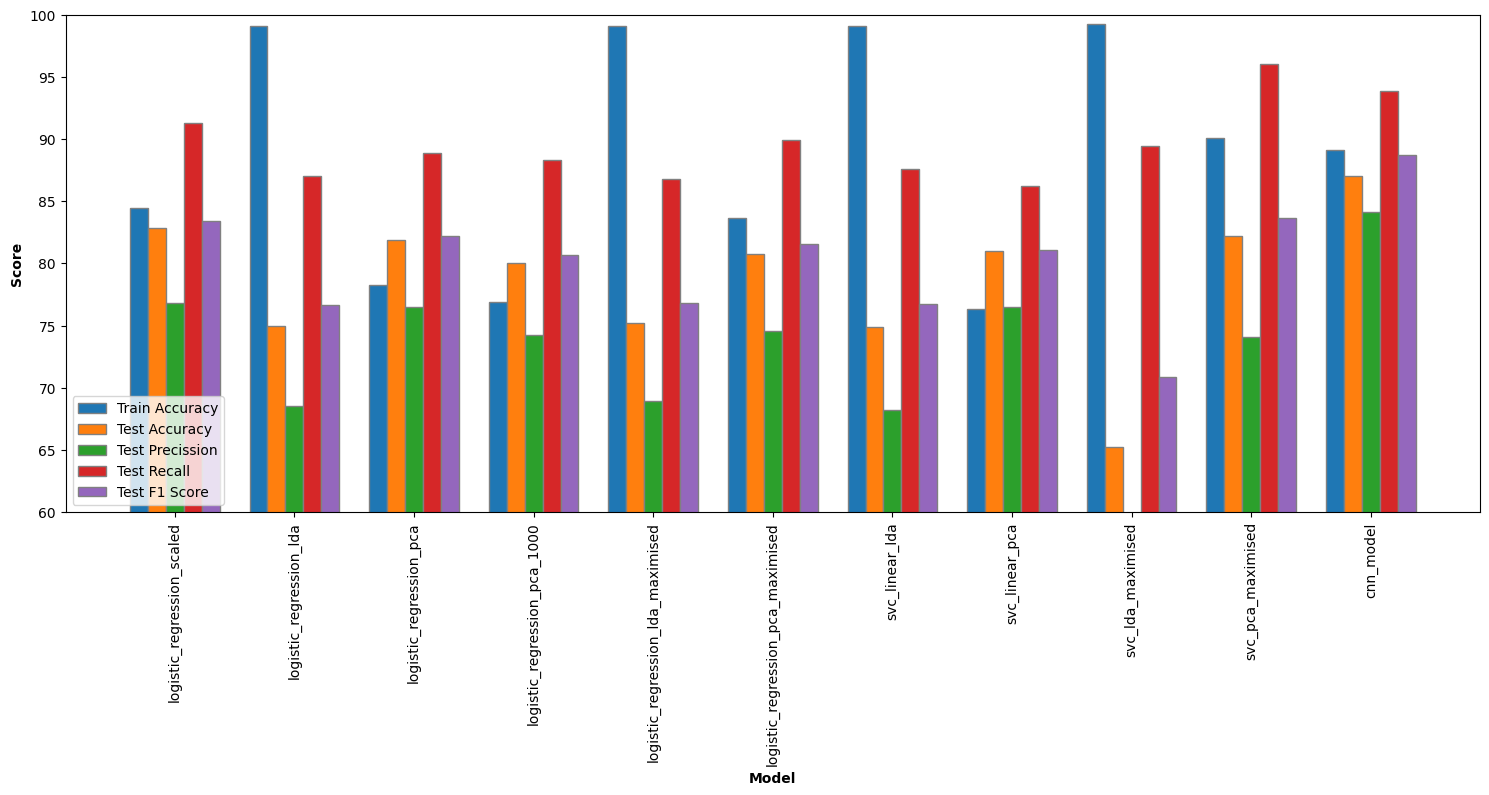

In [ ]:
metrics = ['Train Accuracy', 'Test Accuracy', 'Test Precission', 'Test Recall', 'Test F1 Score']
bar_width = 0.15
r = np.arange(len(Data['Model']))

plt.figure(figsize=(15, 8))

for i, metric in enumerate(metrics):
    plt.bar(r + i * bar_width, Data[metric], color=f'C{i}', width=bar_width, edgecolor='grey', label=metric)

plt.xlabel('Model', fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.xticks(r + bar_width * (len(metrics) - 1) / 2, Data['Model'], rotation=90)
plt.legend(loc='lower left') # Moved legend to upper left
plt.tight_layout()
plt.ylim(60, 100) # Set y-axis limits
plt.show()